# The Neural Network - A Drama 
##By Duncan Wilson 

In [1]:
## import data into a ndarray 
import gzip
import numpy as np 
import random
from scipy.special import expit
f = gzip.open('zip.train.gz', 'rb')
trainData = np.genfromtxt(f)
f.close()
f = gzip.open('zip.test.gz', 'rb')
testData = np.genfromtxt(f)
f.close()

In [2]:
## separate the classes and the training data
Y = trainData[:,0]
X = trainData[:,1:]
## same for test data
Y_test = testData[:,0]
X_test = testData[:,1:]


####As the assignment directed I started by reducing the dimensionality to 20, but was recieving a less than desirable error rate (getting stuck in local minima of error space) on the training data. So after adjustments to the learning rate as well as random restarts, I increased the dimensionality to 30 and started receiving much better error rates. 

In [3]:
## reduce dimensionality down to 40 principle components 
from sklearn.decomposition import PCA
pca = PCA(n_components = 40 )
X_train_pca = pca.fit_transform(X)
train =  list(X_train_pca)

## repeat for test data
X_test_pca = pca.transform(X_test)
test =  list(X_test_pca)


In [4]:
## create target matrix (10 x size of train data [7291]) from target values
yhat = np.zeros((Y.shape[0],10))
for i in range(0 ,Y.shape[0]):
    yhat[i,Y[i]] = 1 
target = list(yhat)
## repeat for test data
yhat_test = np.zeros((Y_test.shape[0],10))
for i in range(0 ,Y_test.shape[0]):
    yhat_test[i,Y_test[i]] = 1 
target_test = list(yhat_test)

In [5]:
## three helper functions used in the neural network class 
def makeMatrix ( I, J, fill=0.0):
  m = []
  for i in range(I):
    m.append([fill]*J)
  return m

def randomMatrix(matrix, lower, upper): 
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            matrix[i][j] = random.uniform(lower, upper)

def sigmoid( signal, derivative=False ):
    signal = expit( signal )
    ## if condition to take partial derivative 
    if derivative:
        return (signal*(1-signal))
    else:
        return signal


In [6]:
class neuralNet: 
    def __init__(self, num_inputs, num_outputs, num_neurons_hl): 
        ## save the numbers for the model 
        self.num_inputs = num_inputs +1 ## add a  for bias term 
        self.num_outputs = num_outputs
        self.num_neurons_hl = num_neurons_hl
        
        ## create the vectors of activation 
        self.activ_input = [1.0]*self.num_inputs
        self.activ_hidden = [1.0]*self.num_neurons_hl
        self.activ_ouput = [1.0]*self.num_outputs
        
        ## create weight matrix 
        self.weight_input = makeMatrix(self.num_inputs, self.num_neurons_hl)
        self.weight_output = makeMatrix(self.num_neurons_hl, self.num_outputs)  
        ## assign small random values to the weight matrices
        randomMatrix(self.weight_input, -0.5, 0.5)
        randomMatrix(self.weight_output, -0.5, 0.5)
        
    ## the feedforward function 
    def runForward(self, train_Data):
        ## catch errors in input size 
        assert len(train_Data) == self.num_inputs-1, "Training data not the same length as number of inputs"
        
        ## assign the inputs
        for i in range(self.num_inputs-1):
            self.activ_input[i] = train_Data[i]
            
        ## run through the first layer 
        for j in range(self.num_neurons_hl):
            sum = 0.0
            for i in range(self.num_inputs):
                sum += (self.activ_input[i] * self.weight_input[i][j])
            self.activ_hidden[j] = sigmoid(sum)
        
        ## run through the hidden layer to output 
        for k in range(self.num_outputs):
            sum = 0.0 
            for j in range(self.num_neurons_hl):
                sum += (self.activ_hidden[j] * self.weight_output[j][k])
            self.activ_ouput[k] = sigmoid(sum)
        
        return self.activ_ouput

    def backProp(self, Y, gamma): 
        ## output deltas 
        delta_output = [0.0]*self.num_outputs
        for k in range(self.num_outputs):
            error = self.activ_ouput[k]- Y[k]
            delta_output[k] = sigmoid(self.activ_ouput[k], True)*error

        ## update output weights
        for j in range(self.num_neurons_hl):
            for k in range(self.num_outputs):
                self.weight_output[j][k] += -(gamma*(self.activ_hidden[j])*delta_output[k])
                
        ## hidden deltas 
        delta_hidden = [0.0]*self.num_neurons_hl
        for j in range(self.num_neurons_hl):
            error = 0.0
            for k in range(self.num_outputs):
                error += delta_output[k] *self.weight_output[j][k]
            delta_hidden[j] = sigmoid(self.activ_hidden[j], True)*error
        
        ## update input weights 
        for i in range(self.num_inputs):
            for j in range(self.num_neurons_hl):
                self.weight_input[i][j] += -(gamma*delta_hidden[j]*self.activ_input[i])
        
        ## calculate total percent error
        totalError = 0.0 
        for k in range(len(Y)):
            totalError += 0.5*(self.activ_ouput[k] - Y[k])**2
        return totalError
    
    def train(self, trainData, target, gamma):
        iterator = 0 
        error = 0.0
        for item in trainData: 
            self.runForward(item)
            error += self.backProp(target[iterator], gamma)
            iterator += 1
        return error 

In [7]:
def percentError(network, train, targets):
    classified_train = [] 
    for i in range(0,len(train)):
        yhat = list(network.runForward(train[i]))
        classified_train.append(yhat.index(max(yhat)))

    truth_train = []
    for i in range(0,len(train)):
        y = list(targets[i])
        truth_train.append(y.index(max(y)))

    dissimilar_train = 0.0
    for i in range(0, len(train)):
        if(truth_train[i] != classified_train[i]):
            dissimilar_train += 1 
    
    percent_error = dissimilar_train/len(train)
    return percent_error

#### Here the network is created and trained. I was really surprised at how few times I had to run the network in order to get the error into the range which was acceptable. 

In [17]:
network = neuralNet(40,10,20)
net_error = network.train(train, target,.1 )

plot_data = []
plot_data.append(net_error)
for i in range(1,10):
    print "Epoch", i, ", total error: ", net_error
    net_error = network.train(train, target, .1)
    plot_data.append(net_error)

Epoch 1 , total error:  1014.71204651
Epoch 2 , total error:  590.203222375
Epoch 3 , total error:  541.245362064
Epoch 4 , total error:  524.687494981
Epoch 5 , total error:  518.925549708
Epoch 6 , total error:  512.879160803
Epoch 7 , total error:  507.350002443
Epoch 8 , total error:  509.192578553
Epoch 9 , total error:  514.235348458


#### Here the train and test data is run through the network and the percent error is calculated and printed below: 

In [18]:
from sklearn.metrics import confusion_matrix
classified_train = [] 
for item in train:
    yhat = list(network.runForward(item))
    classified_train.append(yhat.index(max(yhat)))

truth_train = []
for i in range(0,len(train)):
    y = list(target[i])
    truth_train.append(y.index(max(y)))

classified_test = [] 
for item in test:
    yhat = list(network.runForward(item))
    classified_test.append(yhat.index(max(yhat)))

truth_test = []
for i in range(0,len(test)):
    y = list(target_test[i])
    truth_test.append(y.index(max(y)))

dissimilar_test = 0.0
for i in range(0, len(test)):
    if(truth_test[i] != classified_test[i]):
        dissimilar_test += 1 

dissimilar_train = 0.0
for i in range(0, len(train)):
    if(truth_train[i] != classified_train[i]):
        dissimilar_train += 1 

percent_error = dissimilar_train/len(train)
print "Percent Error train", percent_error
        
percent_error = dissimilar_test/len(test)
print "Percent Error test", percent_error

cm1 = confusion_matrix(truth_train, classified_train)    
cm2 = confusion_matrix(truth_test, classified_test)

Percent Error train 0.0787271979152
Percent Error test 0.119083208769


#### Below are the confusion matrices for both the training and test classification: 

Training Data: 


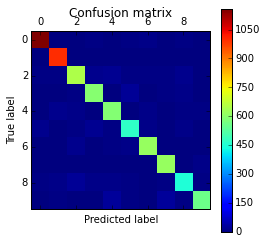

Test Data: 


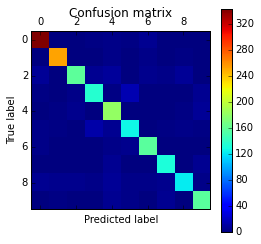

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show confusion matrix in a separate window
print "Training Data: "
plt.matshow(cm1)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Show confusion matrix in a separate window
print "Test Data: "
plt.matshow(cm2)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Below is the code for creating a classification reprot for the data, it gives the various percentages of correct classification on both the training data and test data: 

In [20]:
from sklearn.metrics import classification_report
print classification_report(truth_train, classified_train)
print classification_report(truth_test, classified_test)

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1194
          1       0.95      1.00      0.97      1005
          2       0.91      0.89      0.90       731
          3       0.91      0.91      0.91       658
          4       0.86      0.91      0.89       652
          5       0.88      0.85      0.86       556
          6       0.94      0.93      0.94       664
          7       0.92      0.96      0.94       645
          8       0.87      0.83      0.85       542
          9       0.93      0.87      0.90       644

avg / total       0.92      0.92      0.92      7291

             precision    recall  f1-score   support

          0       0.94      0.96      0.95       359
          1       0.95      0.96      0.96       264
          2       0.91      0.80      0.85       198
          3       0.83      0.82      0.83       166
          4       0.80      0.91      0.85       200
          5       0.81      0.79      0.80